# <center> Практика. ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи

*HR-агентство* изучает тренды на рынке труда в *IT*. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Ключевые вопросы HR-агентства:

- Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?
- Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?
- Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?
- Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.


Данные содержат следующие столбцы:
*   *work_year* — Год, в котором была выплачена зарплата.;
*   *experience_level* — Опыт работы на этой должности в течение года: *EN — Entry-level/Junior, MI — Mid-level/Intermediate, SE — Senior-level/Expert, EX — Executive-level/Director*;
*   *employment_type* — Тип трудоустройства для этой роли: *PT — неполный рабочий день; FT — полный рабочий день; CT — контракт; FL — фриланс*;
*   *job_title* — Роль, в которой соискатель работал в течение года.;
*   *salary* — Общая выплаченная валовая сумма заработной платы.;
*   *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
*   *employee_residence* — 	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения: *0 — удалённой работы нет (менее 20 %); 50 — частично удалённая работа; 100 — полностью удалённая работа (более 80 %)*.
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.;
*   *company_size* — Среднее количество людей, работавших в компании в течение года: *S — менее 50 сотрудников (небольшая компания); M — от 50 до 250 сотрудников (средняя компания); L — более 250 сотрудников (крупная компания)*.

Оригинальный датасет: ["Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка и обработка данных

In [439]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import requests, zipfile, io

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv

import pandas as pd
from ydata_profiling import ProfileReport

# для нормализации, стандартизации
from sklearn import preprocessing

from sklearn.metrics import matthews_corrcoef

import category_encoders as ce # импорт для работы с кодировщиком

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [440]:
# загружаем датасет
#data = pd.read_csv('./ds_salaries.csv')
url = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip'
filename = 'ds_salaries.csv'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

data = pd.read_csv(filename)
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [441]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [442]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

### Проверям датасет на наличие пропусков и дубликатов, а также на корректность типов данных столбцов.


Проверим данные на наличие полных дубликатов:

In [443]:
data = data.drop(['Unnamed: 0'], axis=1)

In [444]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Удаляем неинформативный столбцы 'Unnamed: 0','salary','salary_currency'

In [445]:
data = data.drop(['salary','salary_currency'], axis=1)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


In [446]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(3), object(6)
memory usage: 44.1+ KB


Вывод: И так у нас есть 9 признаков. 1 числовой - **salary_in_usd**. И 8 категориальных - **work_year, experience_level, employment_type, job_title, employee_residence, remote_ratio, company_location, company_size**

### Статистические характеристики каждого из признаков

#### **work_year**

In [447]:
data['work_year'].value_counts()

work_year
2022    278
2021    215
2020     72
Name: count, dtype: int64

- Тип данных: Date
- уникальных значений: 3 (2020, 2021, 2022)



#### **experience_level**

In [448]:
data['experience_level'].describe()

count     565
unique      4
top        SE
freq      243
Name: experience_level, dtype: object

 - Тип данных: Object
 - Уникальных значений: 4
 - Топ: SE (280 ±46%)
 

#### **employment_type**

In [449]:
data['employment_type'].value_counts()

employment_type
FT    546
PT     10
CT      5
FL      4
Name: count, dtype: int64

- Тип данных: object
- Уникальных значений: 4
- Диcбаланс: FT (97% значений - тип трудоустройства: полный рабочий день.)

#### **job_title**

In [450]:
data['job_title'].describe()

count                565
unique                50
top       Data Scientist
freq                 130
Name: job_title, dtype: object

 - тип данных: object
 - уникальных значений: 50
 - самая популярная вакансия: Data Scientist
 - количество упоминаний популярной вакансии: 143

#### **salary_in_usd**

In [451]:
data['salary_in_usd'].describe().round(2).to_frame()

,salary_in_usd
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


**Вывод: Распределение заработной платы отлично от нормального, имеются выбросы.**

#### **employee_residence**

In [452]:
data['employee_residence'].describe()

count     565
unique     57
top        US
freq      295
Name: employee_residence, dtype: object

 - тип данных: object
 - уникальных значений: 57
 - топ: US (332 ±55%)

 **Вывод: больше половины это США**

In [453]:
##создаем признак employee_in_usa для дальнейшего анализа
data['employee_in_usa'] = data['employee_residence'].apply(lambda x: 1 if x == 'US' else 0)

#### **remote_ratio**

In [454]:
data['remote_ratio'].value_counts()

remote_ratio
100    346
0      121
50      98
Name: count, dtype: int64

- тип данных: int64
- уникальных значений: 3

**Вывод: большая часть работы выполняется удалено (381 ±63%)**

#### **company_location**

In [455]:
data['company_location'].describe()

count     565
unique     50
top        US
freq      318
Name: company_location, dtype: object

- тип данных: object
- уникальных значений: 50
- Дисбалансс значений: US

**Вывод: большинство компаний располагаются в США (355 ±59%)**

In [456]:
#создаем признак company_in_usa для дальнейшего анализа
data['company_in_usa'] = data['company_location'].apply(lambda x: 1 if x == 'US' else 0)

#### **company_size**

In [457]:
data['company_size'].describe()

count     565
unique      3
top         M
freq      290
Name: company_size, dtype: object

- тип данных: object
- уникальных значений: 3
- Топ: M

**Вывод: большинство компаний среднего размера (326 ±54%)**

# 2. Разведывательный анализ данных

## 2.1 Визуальный анализ данных

### 2.1.1 Числовые признаки

##### Распреределение заработной платы в USD (salary_in_usd)

In [458]:
data['salary_in_usd'].median()

100000.0

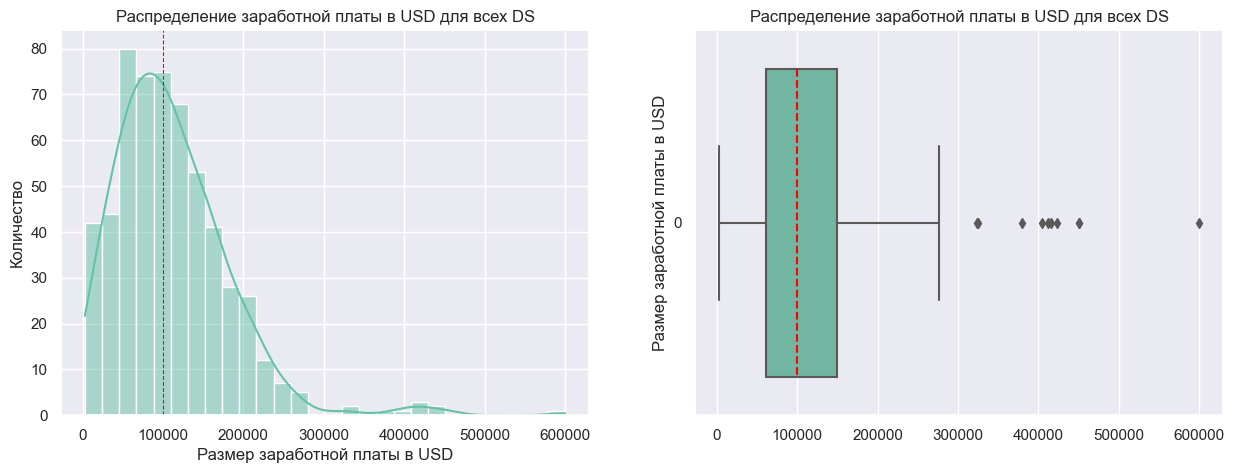

In [459]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в USD', ylabel='Количество')
axes[0].set_title('Распределение заработной платы в USD для всех DS')
axes[0].axvline(data['salary_in_usd'].median(), color='red', linestyle='--', linewidth=0.8)
#axes[0].axvline(data['salary_in_usd'].mode(), color='blue', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы в USD')
axes[1].set_title('Распределение заработной платы в USD для всех DS')

plt.show()

In [460]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер заработной платы в USD']
data_agg

,Размер заработной платы в USD
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


**Вывод: Распределение заработной платы отлично от нормального, имеются выбросы.**

### 2.1.2 Категориальные признаки

##### Распределение объема работы выполняемого удаленно (remote_ratio)

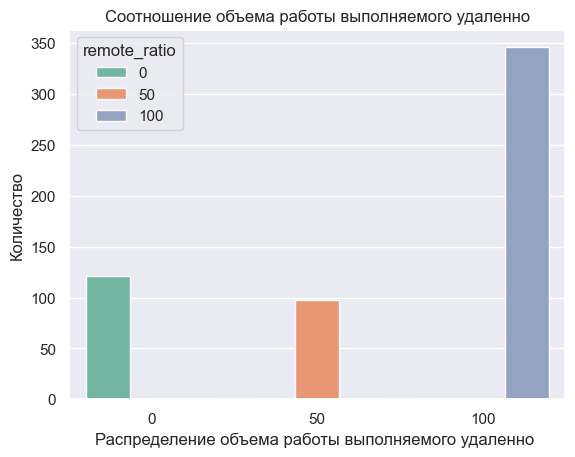

In [461]:
ax = sns.countplot(data=data, x=data['remote_ratio'], hue='remote_ratio')
ax.set(xlabel='Распределение объема работы выполняемого удаленно ', ylabel='Количество')
plt.title('Соотношение объема работы выполняемого удаленно')
plt.show()

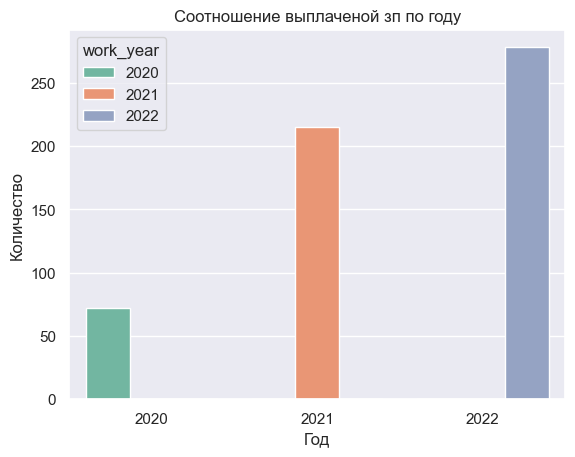

In [462]:
#work_year
ax = sns.countplot(data=data, x=data['work_year'], hue='work_year')
ax.set(xlabel='Год', ylabel='Количество')
plt.title('Соотношение выплаченой зп по году')
plt.show()

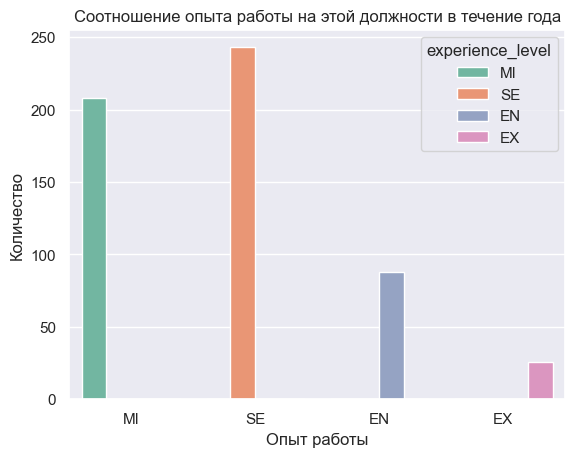

In [463]:
#experience_level
ax = sns.countplot(data=data, x=data['experience_level'], hue='experience_level')
ax.set(xlabel='Опыт работы', ylabel='Количество')
plt.title('Соотношение опыта работы на этой должности в течение года')
plt.show()

**Вывод:Чаще встречаются вакансии для Senior\Lead Expert**

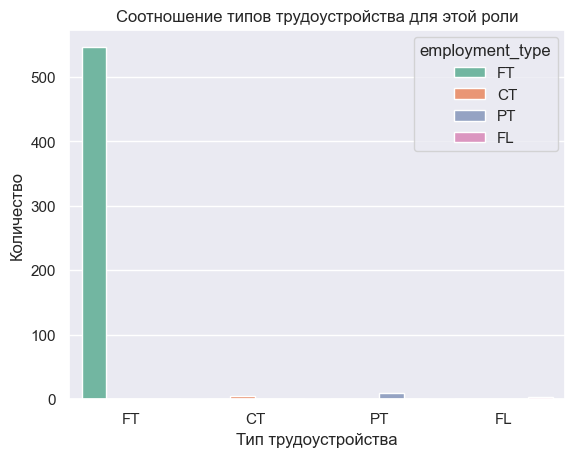

In [464]:
#employment_type
ax = sns.countplot(data=data, x=data['employment_type'], hue='employment_type')
ax.set(xlabel='Тип трудоустройства', ylabel='Количество')
plt.title('Соотношение типов трудоустройства для этой роли')
plt.show()

**Вывод:Чаще встречаются вакансии для Full-Time**

In [465]:
#создаем признак employment_type_FT для дальнейшего анализа
data['employment_type_FT'] = data['employment_type'].apply(lambda x: 1 if x == 'FT' else 0)

In [466]:
#job_title
df_role = data['job_title'].value_counts()
df_role = pd.DataFrame(df_role)
df_role.index = df_role.apply(lambda x: x.name if x.values > 6 else 'Прочее', axis=1)
df_role = df_role.groupby(df_role.index, sort=False, as_index=True).sum()


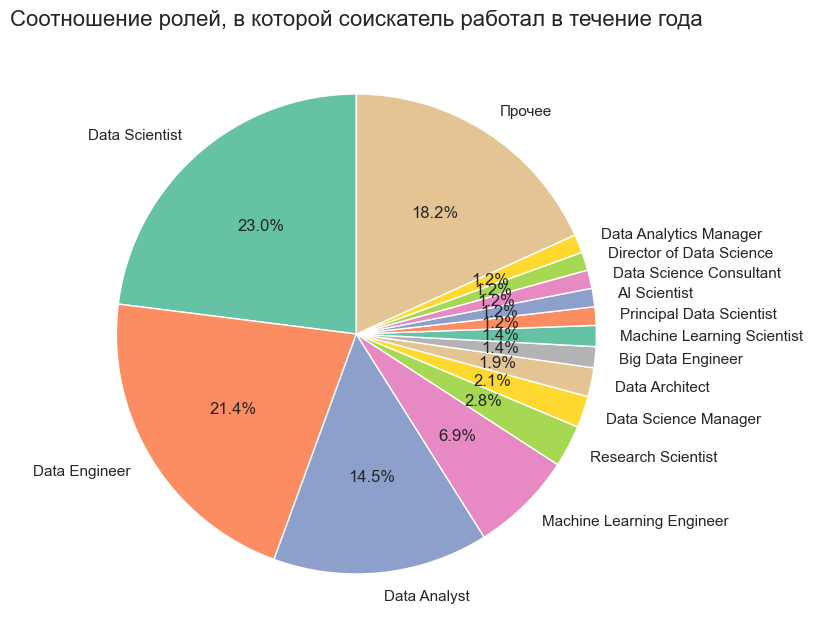

In [467]:
#job_title

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))

pie = ax.pie(
    df_role['count'],
    labels=df_role.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение ролей, в которой соискатель работал в течение года', fontsize=16)
plt.show(pie)


**Вывод: Основные роли это - Data Scientist, Data Engineer, Data Analyst, Machine Learning Engineer**

In [468]:
#создаем признак employment_type_FT для дальнейшего анализа
data['job_title_DS'] = data['job_title'].apply(lambda x: 1 if x == 'Data Scientist' else 0)
data['job_title_DE'] = data['job_title'].apply(lambda x: 1 if x == 'Data Engineer' else 0)

In [469]:
#employee_residence
df_empl = data['employee_residence'].value_counts()
df_empl = pd.DataFrame(df_empl)
df_empl.index = df_empl.apply(lambda x: x.name if x.values > 6 else 'Прочее', axis=1)
df_empl = df_empl.groupby(df_empl.index, sort=False, as_index=True).sum()


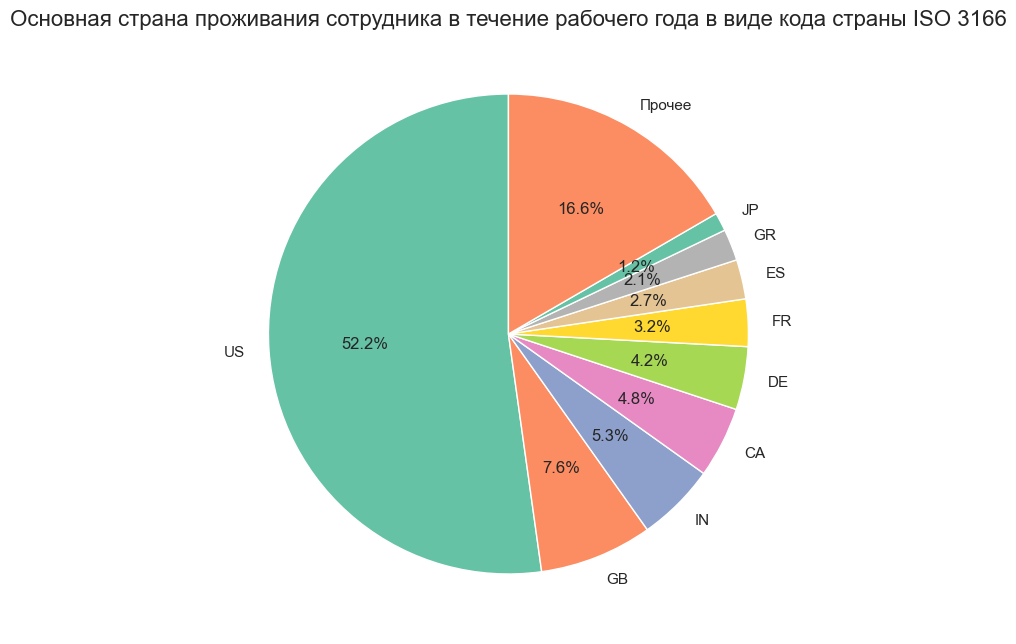

In [470]:
#employee_residence
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))

pie = ax.pie(
    df_empl['count'],
    labels=df_empl.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166', fontsize=16)
plt.show(pie)

**Вывод: Основная страна проживания - US**

In [471]:
#company_location
df_comp = data['company_location'].value_counts()
df_comp = pd.DataFrame(df_comp)
df_comp.index = df_comp.apply(lambda x: x.name if x.values > 5 else 'Прочее', axis=1)
df_comp = df_comp.groupby(df_comp.index, sort=False, as_index=True).sum()

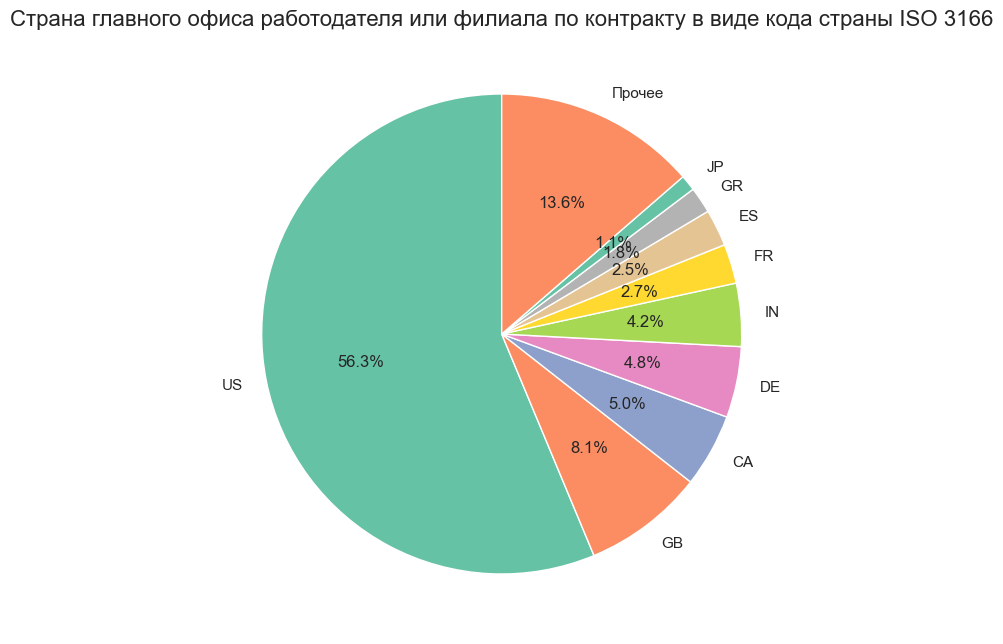

In [472]:
#company_location
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))

pie = ax.pie(
    df_comp['count'],
    labels=df_comp.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166', fontsize=16)
plt.show(pie)

**Вывод: Основная страна главного офиса работодателя - US**

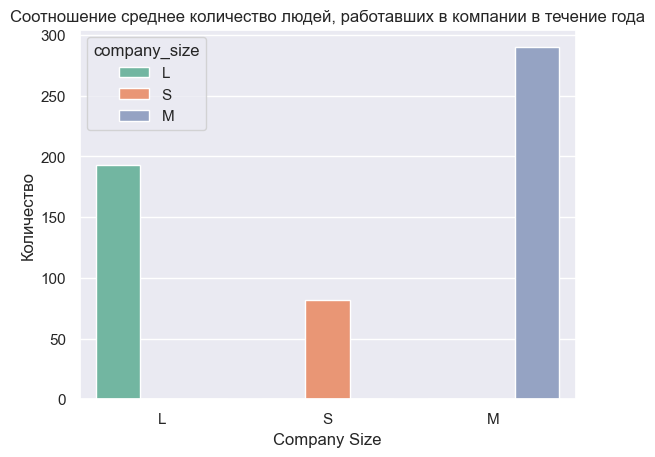

In [473]:
#company_size
ax = sns.countplot(data=data, x=data['company_size'], hue='company_size')
ax.set(xlabel='Company Size', ylabel='Количество')
plt.title('Соотношение cреднее количество людей, работавших в компании в течение года')
plt.show()

**Вывод: больше всего сотрудники работали в средних и больших компаниях.**

In [474]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
 9   employee_in_usa     565 non-null    int64 
 10  company_in_usa      565 non-null    int64 
 11  employment_type_FT  565 non-null    int64 
 12  job_title_DS        565 non-null    int64 
 13  job_title_DE        565 non-null    int64 
dtypes: int64(8), object(6)
memory usage: 82.4+ KB


In [475]:
#кодируем experience_level
encoder = ce.OneHotEncoder(cols=['experience_level'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['experience_level'])
data = pd.concat([data, type_bin], axis=1)

data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employee_in_usa,company_in_usa,employment_type_FT,job_title_DS,job_title_DE,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,0,0,1,1,0,1,0,0,0
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,0,0,1,0,0,0,1,0,0
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,0,0,1,0,0,0,1,0,0
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,0,0,1,0,0,1,0,0,0
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M,1,1,1,0,1,0,1,0,0
603,2022,SE,FT,Data Engineer,126000,US,100,US,M,1,1,1,0,1,0,1,0,0
604,2022,SE,FT,Data Analyst,129000,US,0,US,M,1,1,1,0,0,0,1,0,0
605,2022,SE,FT,Data Analyst,150000,US,100,US,M,1,1,1,0,0,0,1,0,0


In [476]:
encoder = ce.OneHotEncoder(cols=['company_size'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['company_size'])
data = pd.concat([data, type_bin], axis=1)

data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employee_in_usa,...,employment_type_FT,job_title_DS,job_title_DE,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX,company_size_L,company_size_S,company_size_M
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,0,...,1,1,0,1,0,0,0,1,0,0
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,0,...,1,0,0,0,1,0,0,0,1,0
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,0,...,1,0,0,0,1,0,0,0,0,1
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,0,...,1,0,0,1,0,0,0,0,1,0
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,1,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M,1,...,1,0,1,0,1,0,0,0,0,1
603,2022,SE,FT,Data Engineer,126000,US,100,US,M,1,...,1,0,1,0,1,0,0,0,0,1
604,2022,SE,FT,Data Analyst,129000,US,0,US,M,1,...,1,0,0,0,1,0,0,0,0,1
605,2022,SE,FT,Data Analyst,150000,US,100,US,M,1,...,1,0,0,0,1,0,0,0,0,1


In [477]:
encoder = ce.OneHotEncoder(cols=['work_year'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['work_year'])
data = pd.concat([data, type_bin], axis=1)

data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employee_in_usa,...,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX,company_size_L,company_size_S,company_size_M,work_year_2020.0,work_year_2021.0,work_year_2022.0
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,0,...,1,0,0,0,1,0,0,1,0,0
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,0,...,0,1,0,0,0,1,0,1,0,0
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,0,...,0,1,0,0,0,0,1,1,0,0
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,0,...,1,0,0,0,0,1,0,1,0,0
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M,1,...,0,1,0,0,0,0,1,0,0,1
603,2022,SE,FT,Data Engineer,126000,US,100,US,M,1,...,0,1,0,0,0,0,1,0,0,1
604,2022,SE,FT,Data Analyst,129000,US,0,US,M,1,...,0,1,0,0,0,0,1,0,0,1
605,2022,SE,FT,Data Analyst,150000,US,100,US,M,1,...,0,1,0,0,0,0,1,0,0,1


In [478]:
#удаляем перекодированные признаки
data = data.drop(['experience_level','employment_type','company_size','work_year'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_title            565 non-null    object
 1   salary_in_usd        565 non-null    int64 
 2   employee_residence   565 non-null    object
 3   remote_ratio         565 non-null    int64 
 4   company_location     565 non-null    object
 5   employee_in_usa      565 non-null    int64 
 6   company_in_usa       565 non-null    int64 
 7   employment_type_FT   565 non-null    int64 
 8   job_title_DS         565 non-null    int64 
 9   job_title_DE         565 non-null    int64 
 10  experience_level_MI  565 non-null    int64 
 11  experience_level_SE  565 non-null    int64 
 12  experience_level_EN  565 non-null    int64 
 13  experience_level_EX  565 non-null    int64 
 14  company_size_L       565 non-null    int64 
 15  company_size_S       565 non-null    int64 
 16  company_size_

In [479]:
#создаем копию основных данных, удаляем неинформативные признаки
df = data.copy()
df = df.drop(['job_title','employee_residence','company_location'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   salary_in_usd        565 non-null    int64
 1   remote_ratio         565 non-null    int64
 2   employee_in_usa      565 non-null    int64
 3   company_in_usa       565 non-null    int64
 4   employment_type_FT   565 non-null    int64
 5   job_title_DS         565 non-null    int64
 6   job_title_DE         565 non-null    int64
 7   experience_level_MI  565 non-null    int64
 8   experience_level_SE  565 non-null    int64
 9   experience_level_EN  565 non-null    int64
 10  experience_level_EX  565 non-null    int64
 11  company_size_L       565 non-null    int64
 12  company_size_S       565 non-null    int64
 13  company_size_M       565 non-null    int64
 14  work_year_2020.0     565 non-null    int64
 15  work_year_2021.0     565 non-null    int64
 16  work_year_2022.0     565 non-nu

<AxesSubplot:>

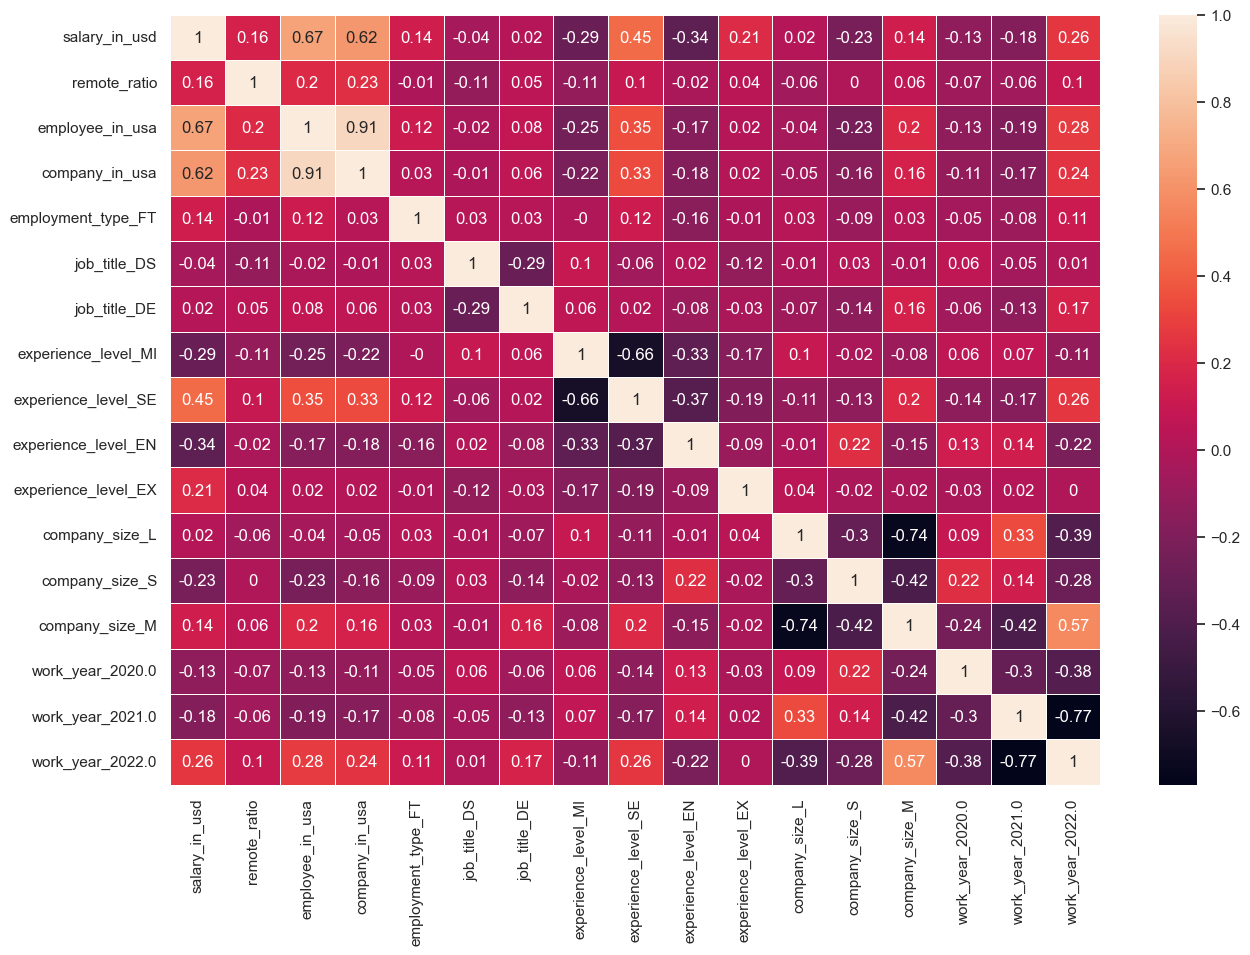

In [480]:
# построим матрицу корреляции, так как есть выбросы используем метод Спирмана
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(round(df.corr(method='spearman'),2), annot = True, linewidths=.5, ax=ax)

**Вывод по матрице корреляции:** Видим сильную связь между проживанием сотрудника в США и расположением главного офиса в США.

**ВЫВОД ПО ВИЗУАЛЬНОМУ АНАЛИЗУ: Какие факторы влияют на заработную плату?**
1. Объем удаленной работы
2. Находится место проживания сотрудника или главный офис в США или нет.
3. Опыт работы SE, EX или другой.
4. Размер компании M или другой.
5. Год выплаты 2022 или другой.

## Статистический анализ данных



In [481]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты в 2020 году ($μ_1$) статистически меньше либо равен размеру зарплаты в 2021 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты в 2020 году ($μ_1$) статистически больше, чем размер зарплаты в 2021 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [482]:
# значения страховых выплат
salary_2020 = df.loc[df['work_year_2020.0']==1, 'salary_in_usd']
salary_2021 = df.loc[df['work_year_2021.0']==1, 'salary_in_usd']
salary_2022 = df.loc[df['work_year_2022.0']==1, 'salary_in_usd']
# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов. Сначала сравниваем 2020 год с 2021, а следом 2021 с 2022

**Проведём тест**

In [483]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2020, salary_2021, alternative='greater')
decision_hypothesis(p)

p-value = 0.752
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер заработной платы в 2020 больше, чем 2021.

In [484]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2021, salary_2022, alternative='greater')
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [485]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2020, salary_2022, alternative='greater')
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер заработной платы в 2021 больше, чем 2022.

**ОБЩИЙ ВЫВОД**

Наблюдается ежегодный рост зарплат у специалистов *Data Scientist*

### Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты для *Data Scientist* ($μ_1$) статистически больше либо равен размеру зарплаты для *Data Engineer* ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты для *Data Scientist*  ($μ_1$) статистически меньше, чем размер зарплаты для *Data Engineer* ($μ_2$).
$$ H_1 : μ_1 < μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [486]:
# значения зп
salary_ds_2022 = df.loc[(df['job_title_DS']==1) & (df['work_year_2022.0']==1), 'salary_in_usd']
salary_de_2022 = df.loc[(df['job_title_DE']==1) & (df['work_year_2022.0']==1), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(salary_de_2022)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [487]:
# проводим тест
_, p = stats.mannwhitneyu(salary_ds_2022, salary_de_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.841
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Размер зарплаты для *Data Scientist* больше, чем для *Data Engineer*.

### Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты специалистов *Data Scientist* не отличается в компаниях различных размеров: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты специалистов *Data Scientist* отличается в компаниях различных размеров: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [488]:
# значения зп
salary_company_l = df.loc[df['company_size_L']==1, 'salary_in_usd']
salary_company_m = df.loc[df['company_size_M']==1, 'salary_in_usd']
salary_company_s = df.loc[df['company_size_S']==1, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для company_size_L:')
result = stats.shapiro(salary_company_l)
decision_normality(result[1])

print('Для company_size_M:')
result = stats.shapiro(salary_company_m)
decision_normality(result[1])

print('Для company_size_S:')
result = stats.shapiro(salary_company_s)
decision_normality(result[1])


Для company_size_L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для company_size_M:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для company_size_S:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [489]:
# проводим тест
_, p = stats.kruskal(salary_company_l, salary_company_m, salary_company_s)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Нет оснований утверждать, что есть нету разницы в размере зарплаты в компаниях разного размера.

### Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, есть ли должность *Data Scientist* и *Data Engineer*, и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, есть ли должность *Data Scientist* и *Data Engineer*, и размером компании есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Должность»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [490]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title_DS'], df['company_size_L'])

cross_table

company_size_L,0,1
job_title_DS,,
0,285,150
1,87,43


In [491]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.848
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [492]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title_DS'], df['company_size_M'])

cross_table

company_size_M,0,1
job_title_DS,,
0,211,224
1,64,66


In [493]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.964
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [494]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title_DS'], df['company_size_S'])

cross_table

company_size_S,0,1
job_title_DS,,
0,374,61
1,109,21


In [495]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.643
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [496]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title_DE'], df['company_size_L'])

cross_table

company_size_L,0,1
job_title_DE,,
0,285,159
1,87,34


In [497]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.140
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [498]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title_DE'], df['company_size_M'])

cross_table

company_size_M,0,1
job_title_DE,,
0,235,209
1,40,81


In [499]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [500]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title_DE'], df['company_size_S'])

cross_table

company_size_S,0,1
job_title_DE,,
0,368,76
1,115,6


In [501]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между должностью *Data Scientist* и компаниями разрмеров L, M, S.
Существует статистически значимая взаимосвязь между должностью *Data Engineer* и компаниями разрмеров L.

### Дополнительное исследование

### Как соотносятся размер зарплаты с опытом работы на этой должности в течение года?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты с опытом работы SE ($μ_1$) статистически меньше либо равен размеру зарплаты c другим опытом работы ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты с опытом работы SE ($μ_1$) статистически больше, чем размер зарплаты c иным опытом работы ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [502]:
# значения страховых выплат
salary_se = df.loc[df['experience_level_SE']==1, 'salary_in_usd']
salary_not_se = df.loc[df['experience_level_SE']==0, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для SE:')
result = stats.shapiro(salary_se)
decision_normality(result[1])

print('Для NOT SE:')
result = stats.shapiro(salary_not_se)
decision_normality(result[1])

Для SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для NOT SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [503]:
# проводим тест
_, p = stats.mannwhitneyu(salary_se, salary_not_se, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Нет оснований утверждать, что размер заработной платы c опытом SE больше, чем с другим опытом.

### Как соотносятся размер зарплаты с объемом удаленной работы?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты с большим объемом удаленной работы ($μ_1$) статистически меньше либо равен размеру зарплаты без объема удаленной работы($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты с большим объемом удаленной работы ($μ_1$) статистически больше, чем размер зарплаты без объема удаленной работы ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [504]:
# значения зп
salary_re = df.loc[df['remote_ratio']==100, 'salary_in_usd']
salary_not_re = df.loc[df['remote_ratio']==0, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для RE:')
result = stats.shapiro(salary_re)
decision_normality(result[1])

print('Для NOT RE:')
result = stats.shapiro(salary_not_re)
decision_normality(result[1])

Для RE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для NOT RE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [505]:
# проводим тест
_, p = stats.mannwhitneyu(salary_re, salary_not_re, alternative='greater')
decision_hypothesis(p)

p-value = 0.018
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Нет оснований утверждать, что размер заработной платы c большим объемом удаленной работы меньше, чем без удаленной работы.

## Итоговые результаты исследования

*   Наблюдается ежегодный рост зарплат у специалистов *Data Scientist*.
*   Размер зарплаты для *Data Scientist* больше, чем для *Data Engineer*
*   Нет оснований утверждать, что есть нету разницы в размере зарплаты в компаниях разного размера.
*   Существует статистически значимая взаимосвязь между должностью *Data Scientist* и компаниями разрмеров L, M, S.
*   Существует статистически значимая взаимосвязь между должностью *Data Engineer* и компаниями разрмеров L.
*   Нет оснований утверждать, что размер заработной платы c опытом SE больше, чем с другим опытом.
*   Нет оснований утверждать, что размер заработной платы c большим объемом удаленной работы меньше, чем без удаленной работы.